# <span style="color:orange"> Laboratorio di Simulazione Numerica </span>
## <span style="color:orange"> Esercitazione 10 </span>

### Paolo Panatti (12606A)

### <font color="blue"> Esercizio 10.1

#### Obiettivo:
Parallelizzare con le librerie MPI (Message Passing Interface) l'algoritmo genetico dell'esercitazione $9$.

Il **calcolo parallelo** consiste nel suddividere un problema in compiti più piccoli e nell'eseguirli simultaneamente su più processori, al fine di ridurre il tempo computazionale e ottenere prestazioni più elevate. Tra i vari paradigmi di programmazione parallela esistenti, a noi interessa in particolare il modello SPMD (Single Program Multiple Data), in cui tutti i processi eseguono lo stesso programma lavorando su set di dati differenti. La comunicazione fra i vari processi può essere gestita, ad esempio, tramite le librerie **MPI** che, implementando un modello *message-passing*, permettono ai nodi di scambiarsi informazioni anche in assenza di uno spazio di indirizzamento comune per la memoria.

Per parallelizzare l'algoritmo genetico dell'esercitazione $9$ (implementato per risolvere il problema del commesso viaggiatore) ho deciso di procedere nel seguente modo: ho suddiviso l'intera popolazione in "continenti" e ciascun nodo, che corrisponde ad uno di questi "continenti", esegue una ricerca indipendente della soluzione evolvendo i propri individui in modo autonomo tramite l'algoritmo genetico. Ogni $N_{migr}$ generazioni, però, due "continenti" scelti casualmente si scambiano i loro individui migliori. Questo meccanismo di "migrazione" contribuisce ad aumentare la diversità genetica e, di conseguenza, favorisce la convergenza verso la soluzione ottimale, evitando che le singole popolazioni restino bloccate in minimi locali.

Il codice è praticamente identico a quello dell'esercitazione $9$, eccetto che per le seguenti aggiunte:
- nella classe ```Popolazione```: la funzione ```initialize_pop()``` riceve in input anche il *rank* del processo e in base a questo inizializza il generatore di numeri casuali in modo diverso, leggendo dal file ```Primes``` una coppia di numeri primi differente. In questo modo, garantiamo il fatto che ogni nodo esegua una ricerca diversa della soluzione. Ho introdotto inoltre il metodo ```migrate()```, che implementa il meccanismo di "migrazione" sopra descritto. Questa funzione viene chiamata all'interno del metodo ```evolve()``` ogni $N_{migr}$ generazioni. Alla fine, ciascun processo produce i propri file di output.
- nel main: inizializzazione di MPI, identificazione di *size* e *rank*, finalizzazione di MPI.

### <font color="blue"> Esercizio 10.2

#### Obiettivo:
Applicare il codice parallelizzato al problema del commesso viaggiatore per i $110$ capoluoghi di provincia italiani.

Ho eseguito la simulazione su $4$ processori, utilizzando i seguenti parametri: $1000$ individui per continente, $1000$ generazioni e $1$ migrazione ogni $N_{migr}=5$ generazioni. Rispetto al codice dell'esercitazione precedente, ho aumentato la probabilità di subire una mutazione a $p_m=0.3$.

Di seguito i grafici con i risultati ottenuti (a sinistra: andamento della lunghezza del percorso più breve e della media delle lunghezze della metà migliore della popolazione in funzione delle generazioni, a destra: percorso migliore in coordinate cartesiane) per ogni processo.

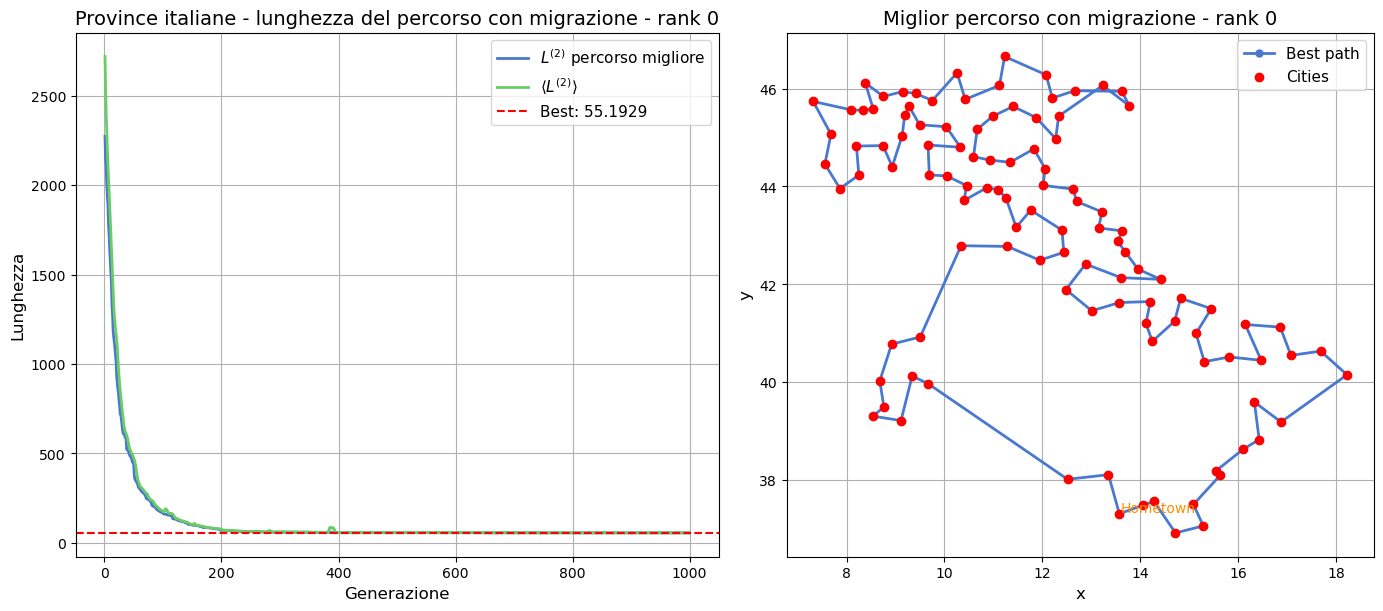

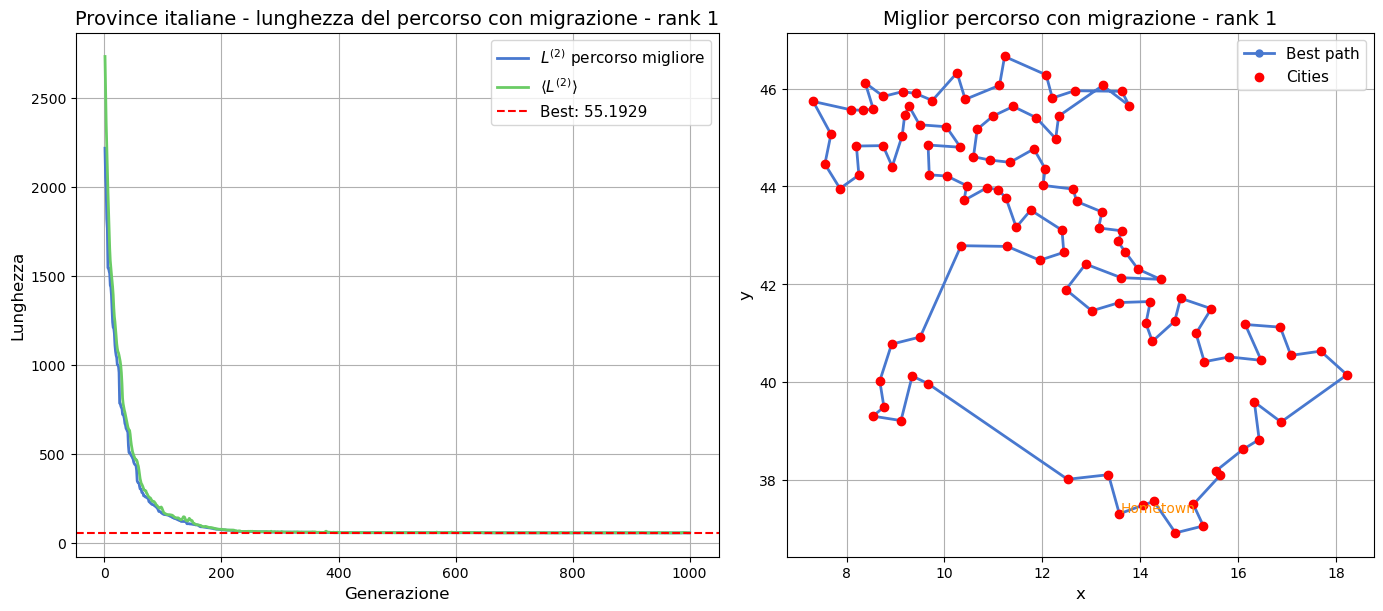

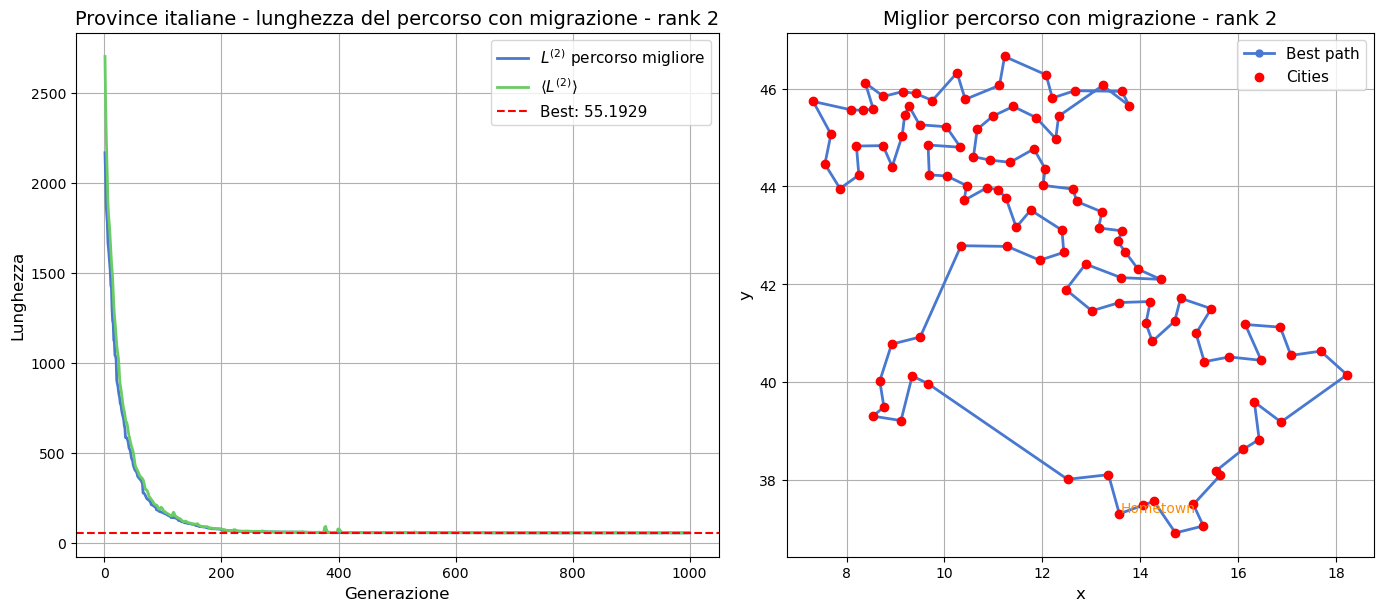

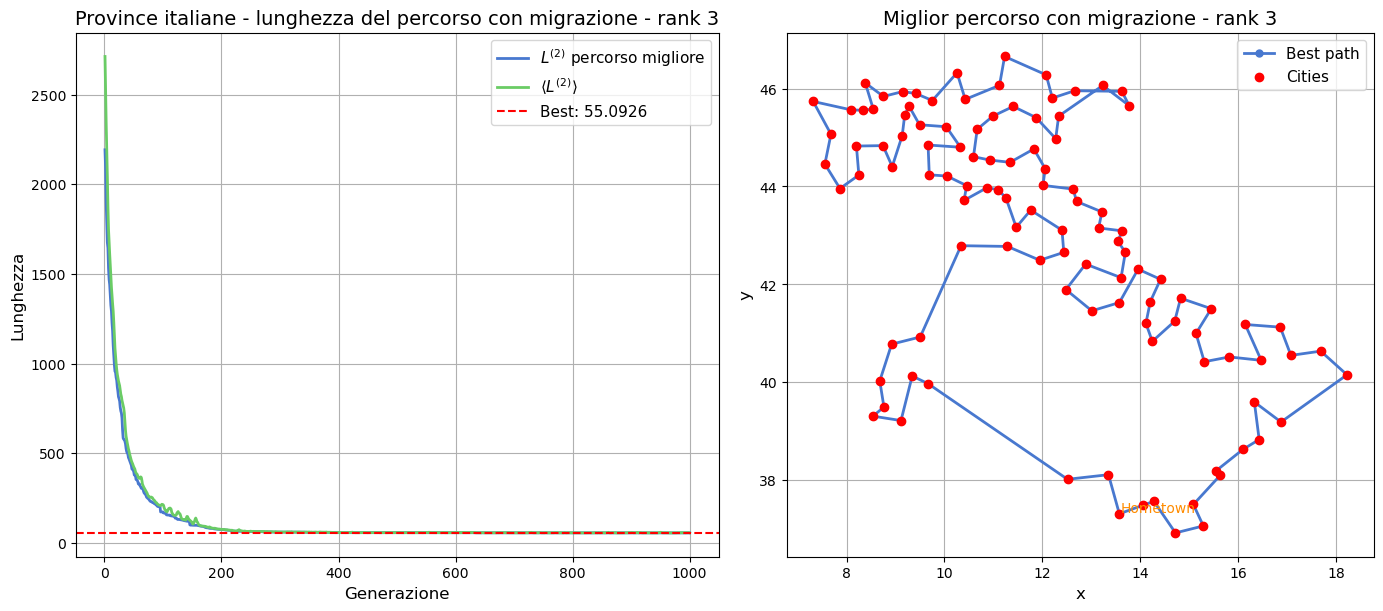

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Stile visivo
plt.style.use("seaborn-v0_8-muted")

x, y = np.loadtxt("cap_prov_ita.dat", usecols=(0,1), unpack=True)

for i in range(4):
    gen = np.arange(1000) + 1
    L2, L2_mean = np.loadtxt(f"ConMigrazione/results_{i}.dat", usecols=(1,2), unpack=True)

    path = np.loadtxt(f"ConMigrazione/best_path{i}.dat", usecols=0, unpack=True).astype(int) - 1
    x_path = np.append(x[path], x[path[0]])
    y_path = np.append(y[path], y[path[0]])

    fig, axes = plt.subplots(1, 2, figsize=(14,6), constrained_layout=True)

    axes[0].plot(gen, L2, label=r"$L^{(2)}$ percorso migliore", lw=2)
    axes[0].plot(gen, L2_mean, label=r"$\langle L^{(2)} \rangle$", lw=2)
    axes[0].axhline(y=L2[-1], color = "red", linestyle = "--", label = "Best: "+str(L2[-1]))
    axes[0].set_xlabel("Generazione", fontsize=12)
    axes[0].set_ylabel("Lunghezza", fontsize=12)
    axes[0].set_title("Province italiane - lunghezza del percorso con migrazione - rank "+str(i), fontsize=14)
    axes[0].legend(fontsize=11)
    axes[0].grid(True)

    axes[1].plot(x_path, y_path, '-o', label='Best path', lw=2, markersize=5, zorder=2)
    axes[1].scatter(x, y, c='red', label='Cities', zorder=3)
    axes[1].text(x[path[0]] + 0.02, y[path[0]] + 0.02, "Hometown", color='darkorange', fontsize=10, zorder=5)
    axes[1].set_title("Miglior percorso con migrazione - rank "+str(i), fontsize=14)
    axes[1].set_xlabel("x", fontsize=12)
    axes[1].set_ylabel("y", fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True)
    axes[1].set_aspect('equal', adjustable='box')

    plt.show()

I risultati finali dei primi tre processori sono esattamente identici. L'ultimo nodo, invece, ha trovato un percorso ancora più breve: probabilmente il percorso in questione è stato creato dopo l'ultima migrazione e quindi non è stato trasferito anche agli altri processi. Ovviamente, data l'enorme complessità del problema, non possiamo essere certi che il percorso trovato corrisponda effettivamente alla soluzione esatta: potrebbe trattarsi di uno dei tanti minimi locali.

Per confrontare l'approccio parallelo con quello seriale, infine, ho eseguito un'ulteriore simulazione utilizzando sempre lo stesso numero di core di calcolo ($4$), ma senza migrazioni: ogni nodo esegue una ricerca completamente indipendente. Come prima, ho lasciato evolvere le varie popolazioni per $1000$ generazioni, ma ho modificato il numero di individui, impostandolo a $4000$, in modo da mantenere invariato il numero totale. Qui in basso i risultati ottenuti.

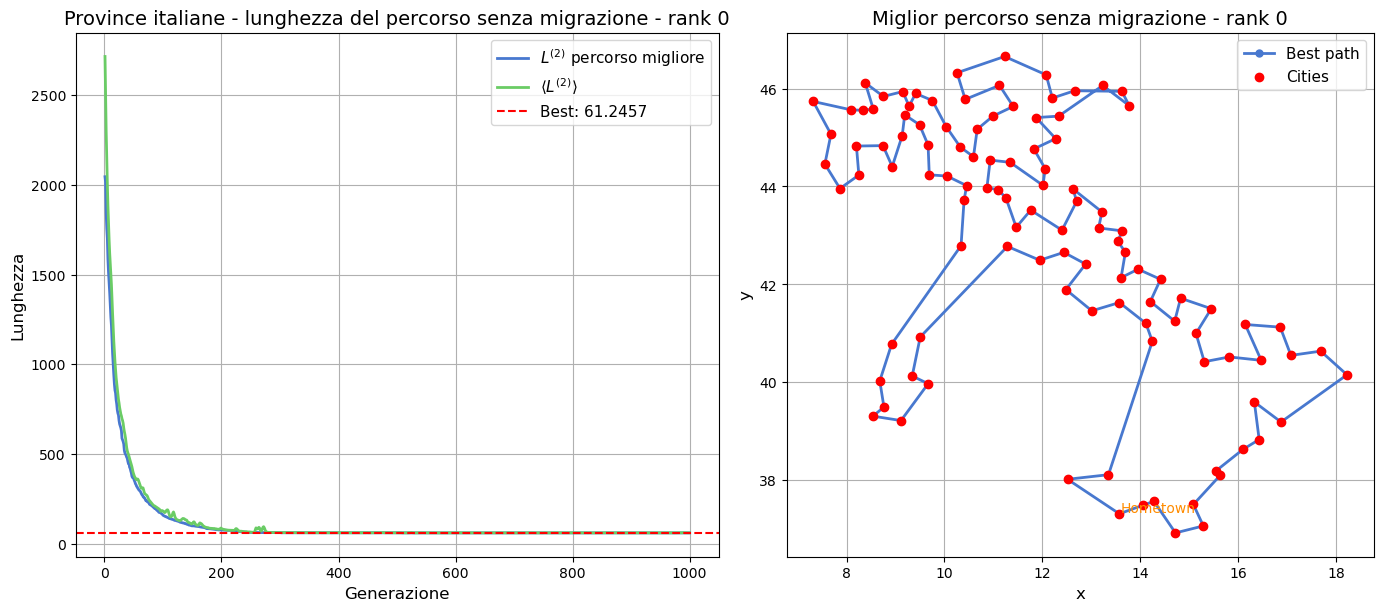

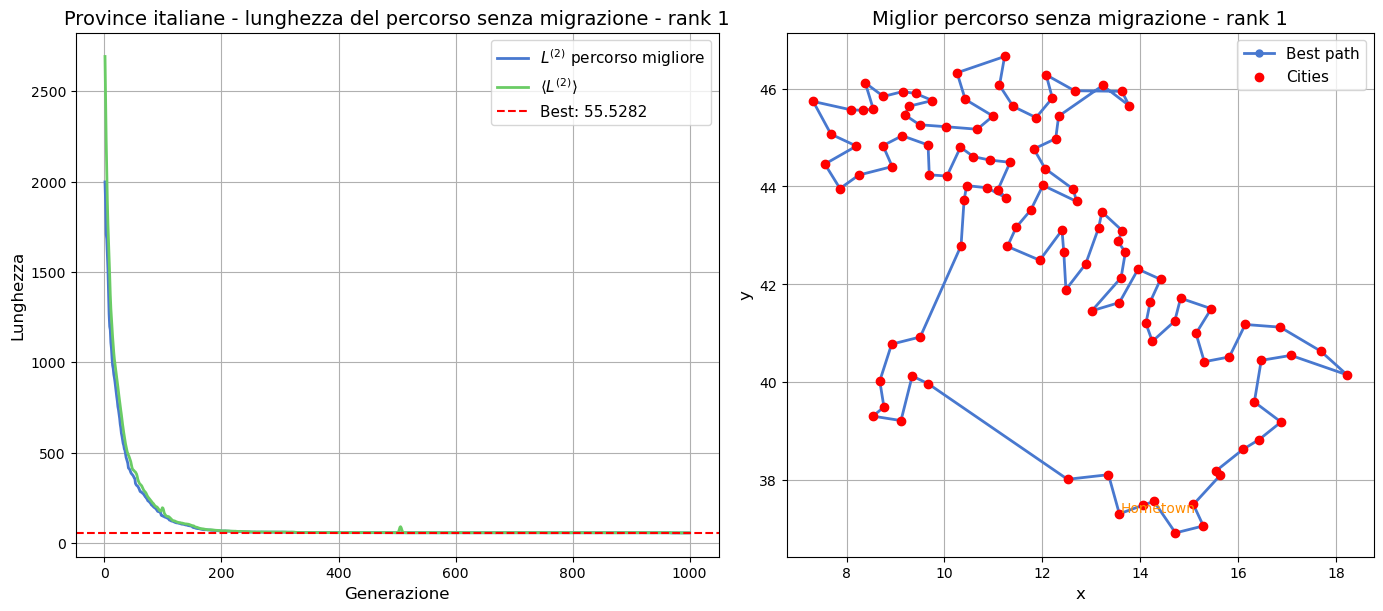

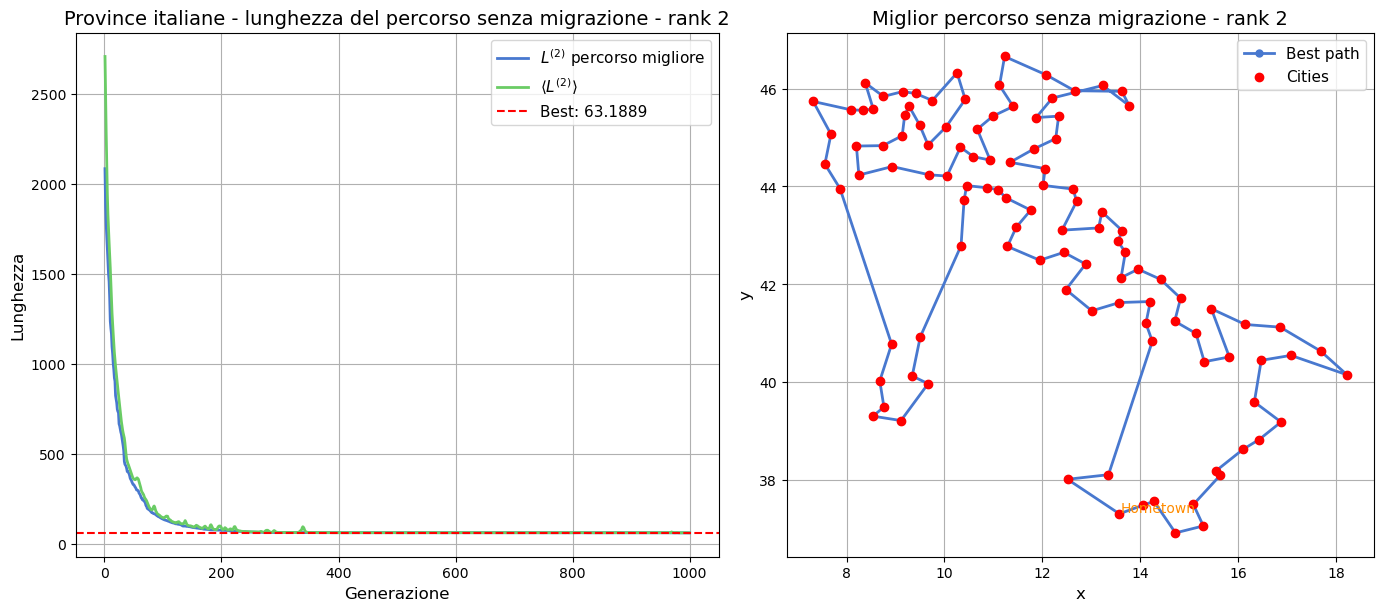

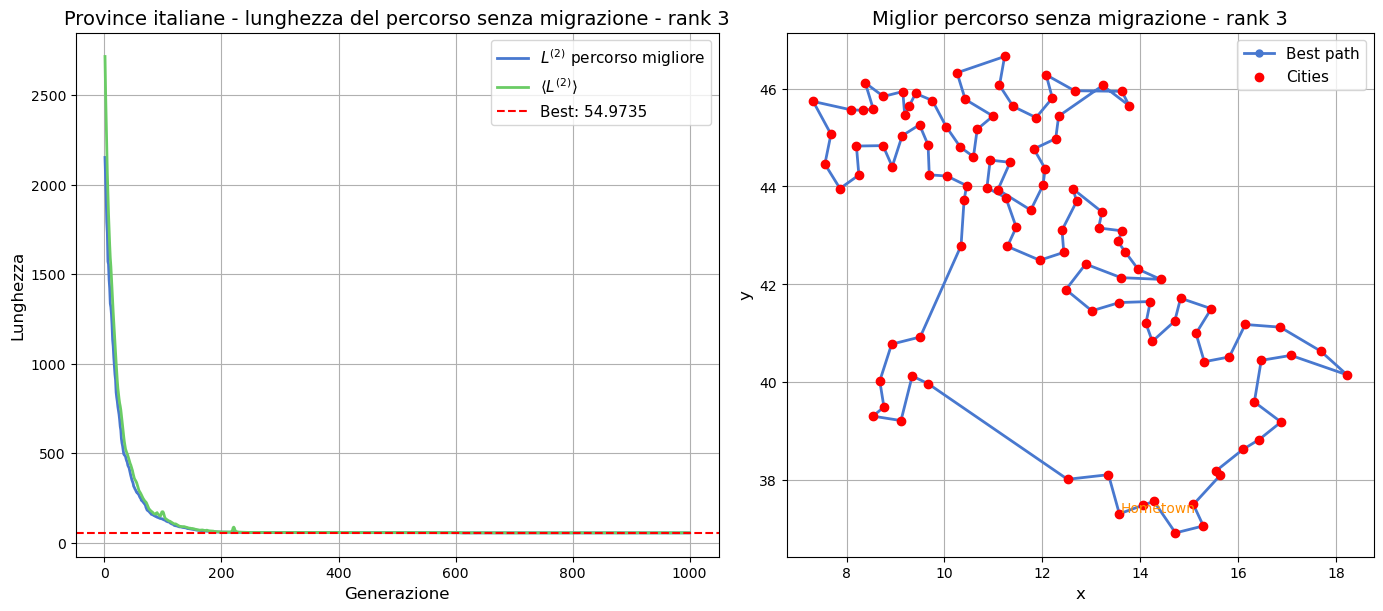

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Stile visivo
plt.style.use("seaborn-v0_8-muted")

x, y = np.loadtxt("cap_prov_ita.dat", usecols=(0,1), unpack=True)

for i in range(4):
    gen = np.arange(1000) + 1
    L2, L2_mean = np.loadtxt(f"SenzaMigrazione/results_{i}.dat", usecols=(1,2), unpack=True)

    path = np.loadtxt(f"SenzaMigrazione/best_path{i}.dat", usecols=0, unpack=True).astype(int) - 1
    x_path = np.append(x[path], x[path[0]])
    y_path = np.append(y[path], y[path[0]])

    fig, axes = plt.subplots(1, 2, figsize=(14,6), constrained_layout=True)

    axes[0].plot(gen, L2, label=r"$L^{(2)}$ percorso migliore", lw=2)
    axes[0].plot(gen, L2_mean, label=r"$\langle L^{(2)} \rangle$", lw=2)
    axes[0].axhline(y=L2[-1], color = "red", linestyle = "--", label = "Best: "+str(L2[-1]))
    axes[0].set_xlabel("Generazione", fontsize=12)
    axes[0].set_ylabel("Lunghezza", fontsize=12)
    axes[0].set_title("Province italiane - lunghezza del percorso senza migrazione - rank "+str(i), fontsize=14)
    axes[0].legend(fontsize=11)
    axes[0].grid(True)

    axes[1].plot(x_path, y_path, '-o', label='Best path', lw=2, markersize=5, zorder=2)
    axes[1].scatter(x, y, c='red', label='Cities', zorder=3)
    axes[1].text(x[path[0]] + 0.02, y[path[0]] + 0.02, "Hometown", color='darkorange', fontsize=10, zorder=5)
    axes[1].set_title("Miglior percorso senza migrazione - rank "+str(i), fontsize=14)
    axes[1].set_xlabel("x", fontsize=12)
    axes[1].set_ylabel("y", fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True)
    axes[1].set_aspect('equal', adjustable='box')

    plt.show()

Chiaramente, questa volta, a differenza del caso con migrazione, i percorsi trovati dai quattro processi sono ben diversi fra loro. L'approccio parallelo consente di individuare percorsi generalmente più brevi rispetto a quello seriale, confermando l'efficacia del meccanismo di migrazione. Tuttavia, notiamo che la soluzione migliore in assoluto è stata trovata dall'ultimo nodo della seconda simulazione. Probabilmente si tratta di un caso particolarmente fortunato. Per migliorare ulteriormente l'algoritmo, si potrebbe pensare ad un meccanismo di migrazione ancora più efficiente.